In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
mess = pd.read_excel('messages.xlsx')
print(mess.shape)

(981, 10)


In [3]:
mess = mess[mess.iloc[:,5]=='M1']
print(mess.shape)

(83, 10)


In [4]:
mess.drop( index = mess[mess.iloc[:,9]=='ТЕХНИЧЕСКИЕ ПЛАНОВЫЕ'].index, inplace=True )
print(mess.shape)
mess.drop( index = mess[mess.iloc[:,9]=='ТЕХНОЛОГИЧЕСКИЕ ПЛАНОВЫЕ'].index, inplace=True )
print(mess.shape)

(75, 10)
(74, 10)


In [5]:
for i in range (4,10):
    mess.iloc[:,2].replace(to_replace='ЭКСГАУСТЕР А/М №{}'.format(i), value=i, inplace=True)

In [6]:
c = mess.columns
mess.drop(columns=c[0:2], inplace=True)
mess.drop(columns=c[3:7], inplace=True)
mess.drop(columns=c[9], inplace=True)

In [7]:
mess.drop(index=mess[mess.iloc[:,1] == mess.iloc[:,2]].index, inplace=True)

In [8]:
new_col_labels = ['N', 'begin', 'end']

col_dict = dict(zip(mess.columns, new_col_labels))
col_dict

{'ИМЯ_МАШИНЫ': 'N',
 'ДАТА_НАЧАЛА_НЕИСПРАВНОСТИ': 'begin',
 'ДАТА_УСТРАНЕНИЯ_НЕИСПРАВНОСТИ': 'end'}

In [9]:
mess.rename(mapper=col_dict, axis=1, inplace=True)

In [10]:
mess = mess.reset_index(drop=True)
print(mess.shape)

(71, 3)


In [11]:
mess.head(10)

,N,begin,end
0,9,2019-03-19 14:00:16,2019-03-19 14:19:19
1,6,2019-05-01 16:29:38,2019-05-01 19:18:04
2,5,2019-05-04 09:50:13,2019-05-04 10:37:22
3,4,2019-05-18 08:27:00,2019-05-18 08:35:51
4,4,2019-05-29 16:56:26,2019-05-29 16:58:29
5,7,2019-05-30 07:58:27,2019-05-30 08:13:29
6,4,2019-07-10 21:43:55,2019-07-10 22:41:02
7,4,2019-07-30 19:14:34,2019-07-30 19:20:35
8,8,2019-08-29 18:49:31,2019-08-29 19:17:37
9,8,2019-10-29 10:22:00,2019-10-29 10:34:00


In [12]:
mess.end = mess.end.apply(lambda t: t.ceil('10S'))
mess.begin = mess.begin.apply(lambda t: t.floor('10S'))

In [13]:
mess.head(10)

,N,begin,end
0,9,2019-03-19 14:00:10,2019-03-19 14:19:20
1,6,2019-05-01 16:29:30,2019-05-01 19:18:10
2,5,2019-05-04 09:50:10,2019-05-04 10:37:30
3,4,2019-05-18 08:27:00,2019-05-18 08:36:00
4,4,2019-05-29 16:56:20,2019-05-29 16:58:30
5,7,2019-05-30 07:58:20,2019-05-30 08:13:30
6,4,2019-07-10 21:43:50,2019-07-10 22:41:10
7,4,2019-07-30 19:14:30,2019-07-30 19:20:40
8,8,2019-08-29 18:49:30,2019-08-29 19:17:40
9,8,2019-10-29 10:22:00,2019-10-29 10:34:00


In [14]:
td = pd.Timedelta(600, "s")

In [15]:
mess['dur'] = np.ceil((mess.end - mess.begin) / td - 0.1)

In [16]:
mess

,N,begin,end,dur
0,9,2019-03-19 14:00:10,2019-03-19 14:19:20,2.0
1,6,2019-05-01 16:29:30,2019-05-01 19:18:10,17.0
2,5,2019-05-04 09:50:10,2019-05-04 10:37:30,5.0
3,4,2019-05-18 08:27:00,2019-05-18 08:36:00,1.0
4,4,2019-05-29 16:56:20,2019-05-29 16:58:30,1.0
...,...,...,...,...
66,5,2021-11-30 14:34:40,2021-11-30 14:42:50,1.0
67,5,2021-12-09 16:46:40,2021-12-09 16:53:50,1.0
68,5,2021-12-16 03:38:40,2021-12-16 03:56:50,2.0
69,5,2021-12-22 17:29:50,2021-12-22 17:37:00,1.0


In [17]:
mess['delta'] = pd.Timedelta(0, "H")
mess['m1_no_begin'] = 0

for i in mess.index:
    
    delta = pd.Timedelta(0, "H")
    if i>0:
        delta = mess.loc[i,'begin'] - mess.loc[i-1,'end']
        mess.loc[i,'delta'] = delta
        
    if delta > pd.Timedelta(40, "H"):
        mess.loc[i,'m1_no_begin'] = mess.loc[i-1,'end'] + pd.Timedelta(24, "H")

In [18]:
mess.head(20)

,N,begin,end,dur,delta,m1_no_begin
0,9,2019-03-19 14:00:10,2019-03-19 14:19:20,2.0,0 days 00:00:00,0
1,6,2019-05-01 16:29:30,2019-05-01 19:18:10,17.0,43 days 02:10:10,2019-03-20 14:19:20
2,5,2019-05-04 09:50:10,2019-05-04 10:37:30,5.0,2 days 14:32:00,2019-05-02 19:18:10
3,4,2019-05-18 08:27:00,2019-05-18 08:36:00,1.0,13 days 21:49:30,2019-05-05 10:37:30
4,4,2019-05-29 16:56:20,2019-05-29 16:58:30,1.0,11 days 08:20:20,2019-05-19 08:36:00
5,7,2019-05-30 07:58:20,2019-05-30 08:13:30,2.0,0 days 14:59:50,0
6,4,2019-07-10 21:43:50,2019-07-10 22:41:10,6.0,41 days 13:30:20,2019-05-31 08:13:30
7,4,2019-07-30 19:14:30,2019-07-30 19:20:40,1.0,19 days 20:33:20,2019-07-11 22:41:10
8,8,2019-08-29 18:49:30,2019-08-29 19:17:40,3.0,29 days 23:28:50,2019-07-31 19:20:40
9,8,2019-10-29 10:22:00,2019-10-29 10:34:00,2.0,60 days 15:04:20,2019-08-30 19:17:40


In [19]:
mess[mess.m1_no_begin != 0].shape

(55, 6)

In [20]:
mess.to_csv('output/mess.csv')

In [21]:
m1_ts = pd.DataFrame(columns=mess.columns[0:2])

ind_m1_ts = 0

for ind_mess in mess.index:

    N = mess.N[ind_mess]
    begin = mess.begin[ind_mess]

    for slot_n in range(int(mess.dur[ind_mess])):
        m1_ts.loc[ind_m1_ts,'N'] = N
        m1_ts.loc[ind_m1_ts,'begin'] = begin
        begin += td
        ind_m1_ts += 1


In [22]:
m1_ts

,N,begin
0,9,2019-03-19 14:00:10
1,9,2019-03-19 14:10:10
2,6,2019-05-01 16:29:30
3,6,2019-05-01 16:39:30
4,6,2019-05-01 16:49:30
...,...,...
663,5,2021-12-09 16:46:40
664,5,2021-12-16 03:38:40
665,5,2021-12-16 03:48:40
666,5,2021-12-22 17:29:50


In [23]:
mess.dur.sum()

668.0

In [24]:
m1_ts.to_csv('output/m1_ts.csv')

In [25]:
m1_pre_ts = pd.DataFrame(columns=mess.columns[0:2])

ind_m1_pre_ts = 0

pre_ts_n = 18 #3 * 6 # 3 часа == 18 тайм-слотов

for ind_mess in mess.index:

    N = mess.N[ind_mess]
    begin = mess.begin[ind_mess] - td * pre_ts_n

    for slot_n in range(pre_ts_n):
        m1_pre_ts.loc[ind_m1_pre_ts,'N'] = N
        m1_pre_ts.loc[ind_m1_pre_ts,'begin'] = begin
        begin += td
        ind_m1_pre_ts += 1


In [26]:
m1_pre_ts

,N,begin
0,9,2019-03-19 11:00:10
1,9,2019-03-19 11:10:10
2,9,2019-03-19 11:20:10
3,9,2019-03-19 11:30:10
4,9,2019-03-19 11:40:10
...,...,...
1273,9,2021-12-29 15:37:00
1274,9,2021-12-29 15:47:00
1275,9,2021-12-29 15:57:00
1276,9,2021-12-29 16:07:00


In [27]:
m1_pre_m1_ts = m1_ts.shape[0] + m1_pre_ts.shape[0]
print(m1_pre_m1_ts)

1946


In [28]:
m1_pre_ts.to_csv('output/m1_pre_ts.csv')

In [29]:
print(m1_pre_m1_ts/6/6, 'часов на блок')
print(m1_pre_m1_ts/6, 'тайм-слотов на блок')


54.05555555555555 часов на блок
324.3333333333333 тайм-слотов на блок


In [30]:
m1_no_ts = pd.DataFrame(columns=mess.columns[0:2])

no_ts_n = 4 * 6 # 2 часа == 12 тайм-слотов
ind_m1_no = 0


for date_no_m1 in mess.m1_no_begin:
    if date_no_m1 != 0:
        for ind in range(no_ts_n):
            for N in range(4,10):

                m1_no_ts.loc[ind_m1_no, 'N'] = N
                m1_no_ts.loc[ind_m1_no, 'begin'] = date_no_m1 + td * ind
                ind_m1_no += 1

In [31]:
m1_no_ts.head(20)

,N,begin
0,4,2019-03-20 14:19:20
1,5,2019-03-20 14:19:20
2,6,2019-03-20 14:19:20
3,7,2019-03-20 14:19:20
4,8,2019-03-20 14:19:20
5,9,2019-03-20 14:19:20
6,4,2019-03-20 14:29:20
7,5,2019-03-20 14:29:20
8,6,2019-03-20 14:29:20
9,7,2019-03-20 14:29:20


In [32]:
m1_no_ts.shape

(7920, 2)

In [33]:
m1_no_ts.to_csv('output/m1_no_ts.csv')

In [34]:
test_int = pd.read_excel('test_intervals.xlsx')
print(test_int.shape)

(189, 5)


In [35]:
c = test_int.columns
test_int.drop(columns=c[0], inplace=True)
test_int.drop(columns=c[2:5], inplace=True)

In [36]:
test_int.start = test_int.start.apply(lambda t: t.floor('10S'))

In [37]:
test_int

,start
0,2022-01-01 10:54:50
1,2022-01-02 12:26:40
2,2022-01-04 12:06:00
3,2022-01-04 20:13:50
4,2022-01-07 09:05:10
...,...
184,2023-04-07 15:36:40
185,2023-04-09 19:55:40
186,2023-04-10 18:08:20
187,2023-04-18 02:28:40


In [38]:
test_int.drop(index=[186,187,188], inplace=True)

In [39]:
test_ts = pd.DataFrame(columns=mess.columns[0:2])

ind_test_ts = 0

test_ts_n = 3 * 6 # 3 часа == 18 тайм-слотов

for N in range(4,10):
    for ind_test_int in test_int.index:

        begin = test_int.start[ind_test_int] - td * test_ts_n

        for slot_n in range(test_ts_n):
            test_ts.loc[ind_test_ts,'N'] = N
            test_ts.loc[ind_test_ts,'begin'] = begin
            begin += td
            ind_test_ts += 1

In [40]:
test_ts.head(20)

,N,begin
0,4,2022-01-01 07:54:50
1,4,2022-01-01 08:04:50
2,4,2022-01-01 08:14:50
3,4,2022-01-01 08:24:50
4,4,2022-01-01 08:34:50
5,4,2022-01-01 08:44:50
6,4,2022-01-01 08:54:50
7,4,2022-01-01 09:04:50
8,4,2022-01-01 09:14:50
9,4,2022-01-01 09:24:50


In [41]:
test_ts.to_csv('output/test_ts.csv')

In [42]:
pd.read_parquet('X_train.parquet').interpolate().to_parquet('output/X_train_interpol.parquet')

In [43]:
pd.read_parquet('X_test.parquet').interpolate().to_parquet('output/X_test_interpol.parquet')

In [44]:
def get_chunk_x_from_file(filename, time_stamp, exh_n):
    
    col1 = (exh_n - 4)*16
    col2 = col1 + 16
    
    chunk = pd.read_parquet(filename).loc[time_stamp:time_stamp + td,:].iloc[:,col1:col2]
    #chunk.drop(index=chunk.index[-1], inplace=True)
    
    #new_col_labels = ['c1', 'c2', 'c3', 'p1', 't1', 't2', 't3', 't4', 'u1', 'u2', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']

    #suffix = '_' + str(exh_n)

    #new_col_labels = [L + suffix for L in new_col_labels]

    #col_dict = dict(zip(chunk.columns, new_col_labels))
    #chunk.rename(mapper=col_dict, axis=1, inplace=True)

    return chunk.to_numpy()

In [45]:
def get_chunk_x_from_mem(df, time_stamp, exh_n):
    
    col1 = (exh_n - 4)*16
    col2 = col1 + 16
    
    chunk = df.loc[time_stamp:time_stamp + td,:].iloc[:,col1:col2]
    #chunk.drop(index=chunk.index[-1], inplace=True)
    
    #new_col_labels = ['c1', 'c2', 'c3', 'p1', 't1', 't2', 't3', 't4', 'u1', 'u2', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']

    #suffix = '_' + str(exh_n)

    #new_col_labels = [L + suffix for L in new_col_labels]

    #col_dict = dict(zip(chunk.columns, new_col_labels))
    #chunk.rename(mapper=col_dict, axis=1, inplace=True)

    return chunk.to_numpy()

In [46]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    
    try:
        plt.plot(history.history['val_loss'], label='val_loss')
    except:
        print('No validation data')

    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)

In [47]:
X_train_interpol = pd.read_parquet('output/X_train_interpol.parquet')
X_test_interpol = pd.read_parquet('output/X_test_interpol.parquet')

In [48]:
x_train = []
y_train = []  # 3 класса: 1=M1, 2=pre-M1, 0=остальное

for ind in m1_ts.index:
    x_train.append(get_chunk_x_from_mem(X_train_interpol, m1_ts.begin[ind], m1_ts.N[ind]))
    y_train.append(np.array([0,1,0]))
    
for ind in m1_pre_ts.index:
    x_train.append(get_chunk_x_from_mem(X_train_interpol, m1_pre_ts.begin[ind], m1_pre_ts.N[ind]))
    y_train.append(np.array([0,0,1]))

for ind in m1_no_ts.index:
    x_train.append(get_chunk_x_from_mem(X_train_interpol, m1_no_ts.begin[ind], m1_no_ts.N[ind]))
    y_train.append(np.array([1,0,0]))
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [49]:
print(x_train.shape)
print(y_train.shape)

(9866, 61, 16)
(9866, 3)


In [50]:
x_test = []

for ind in test_ts.index:
    x_test.append(get_chunk_x_from_mem(X_test_interpol, test_ts.begin[ind], test_ts.N[ind]))

print(ind)
x_test = np.array(x_test)

20087


In [51]:
mms = MinMaxScaler()

In [52]:
x_train = mms.fit_transform(x_train.reshape(-1,16)).reshape(-1,61,16)

In [53]:
x_test = mms.transform(x_test.reshape(-1,16)).reshape(-1,61,16)

In [54]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=17)

model_m = Sequential()
model_m.add(Conv1D(80, 6, activation='relu', input_shape=(61, 16)))
model_m.add(Conv1D(80, 6, activation='relu'))
model_m.add(MaxPooling1D(3))
#model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_m.add(Dropout(0.3))
model_m.add(Dense(170, activation='relu'))
model_m.add(Dense(3, activation='softmax'))
print(model_m.summary())

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_m.fit(x_train, y_train, batch_size=10, epochs=160, validation_data=(x_val, y_val), verbose=2)

In [55]:
model_m = Sequential()
model_m.add(Conv1D(80, 6, activation='relu', input_shape=(61, 16), kernel_regularizer=regularizers.l2(0.01)))
model_m.add(Conv1D(80, 6, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 6, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_m.add(Conv1D(160, 6, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_m.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_m.add(Dropout(0.3))
model_m.add(Dense(170, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_m.add(Dense(3, activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 80)            7760      
                                                                 
 conv1d_1 (Conv1D)           (None, 51, 80)            38480     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17, 80)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 160)           76960     
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 160)            153760    
                                                                 
 G_A_P_1D (GlobalAveragePool  (None, 160)              0         
 ing1D)                                                 

In [56]:
model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [58]:
history = model_m.fit(x_train, y_train, batch_size=10, epochs=160, validation_data=(x_val, y_val), verbose=2, callbacks=[early_stopping])

Epoch 1/160
839/839 - 13s - loss: 0.9597 - accuracy: 0.8019 - val_loss: 0.6298 - val_accuracy: 0.8047 - 13s/epoch - 15ms/step
Epoch 2/160
839/839 - 8s - loss: 0.6226 - accuracy: 0.8024 - val_loss: 0.6871 - val_accuracy: 0.8047 - 8s/epoch - 9ms/step
Epoch 3/160
839/839 - 7s - loss: 0.6128 - accuracy: 0.8024 - val_loss: 0.6083 - val_accuracy: 0.8047 - 7s/epoch - 9ms/step
Epoch 4/160
839/839 - 7s - loss: 0.6051 - accuracy: 0.8024 - val_loss: 0.6116 - val_accuracy: 0.8047 - 7s/epoch - 8ms/step
Epoch 5/160
839/839 - 7s - loss: 0.5967 - accuracy: 0.8024 - val_loss: 0.5918 - val_accuracy: 0.8047 - 7s/epoch - 8ms/step
Epoch 6/160
839/839 - 7s - loss: 0.5892 - accuracy: 0.8043 - val_loss: 0.5873 - val_accuracy: 0.8128 - 7s/epoch - 9ms/step
Epoch 7/160
839/839 - 7s - loss: 0.5787 - accuracy: 0.8067 - val_loss: 0.5637 - val_accuracy: 0.8122 - 7s/epoch - 9ms/step
Epoch 8/160
839/839 - 7s - loss: 0.5715 - accuracy: 0.8073 - val_loss: 0.5675 - val_accuracy: 0.8047 - 7s/epoch - 9ms/step
Epoch 9/160
8

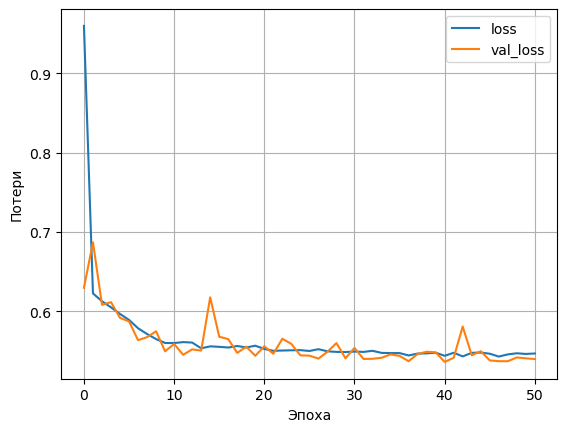

In [59]:
plot_loss(history)

In [60]:
pred = model_m.predict(x_test)

628/628 [==============================] - 2s 3ms/step


In [61]:
print(pred.shape)

predl = []

for i in range(pred.shape[0]):
    predl.append(np.argmax(pred[i]))
    
predl = np.array(predl).reshape(-1,18)
df = pd.DataFrame(predl.ravel())

df.value_counts()

(20088, 3)


0    19849
1      225
2       14
dtype: int64

In [62]:
predl.shape

(1116, 18)

In [63]:
out = []

for i in range(predl.shape[0]):
    t = 1 if predl[i].sum() > 10 else 0
    out.append(t)

out = np.array(out).reshape(-1,186).transpose()

In [64]:
out = pd.DataFrame(out, columns=['Ex4','Ex5','Ex6','Ex7','Ex8','Ex9'])

In [65]:
out

,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
181,0,0,0,0,0,0
182,0,0,0,0,0,0
183,0,0,0,0,0,0
184,0,0,0,0,0,0


In [66]:
out.sum().sum()

13